# Assignment 3 Timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [9]:
import os
import zipfile
import urllib.request


url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"
filename = "jena_climate_2009_2016.csv.zip"
unzipped_filename = "jena_climate_2009_2016.csv"


if not os.path.exists(filename):
    # File doesn't exist, download it
    urllib.request.urlretrieve(url, filename)

if os.path.exists(filename):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()
        print(f"{filename} unzipped successfully.")
else:
    print("File not found and could not be downloaded.")

jena_climate_2009_2016.csv.zip unzipped successfully.


**Inspecting the data of the Jena weather dataset**

In [10]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [11]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

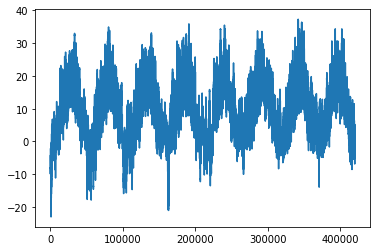

In [12]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

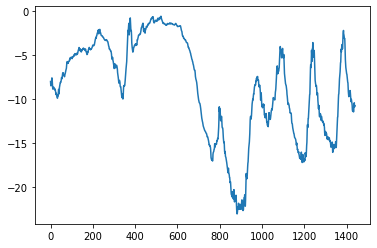

In [13]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [14]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [15]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [16]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [17]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [18]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [19]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 11s 13ms/step - loss: 13.9448 - mae: 2.8816 - val_loss: 11.8385 - val_mae: 2.7109
Epoch 2/10
819/819 [==============================] - 10s 12ms/step - loss: 9.5494 - mae: 2.4295 - val_loss: 11.5174 - val_mae: 2.6705
Epoch 3/10
819/819 [==============================] - 10s 12ms/step - loss: 8.6813 - mae: 2.3187 - val_loss: 11.5283 - val_mae: 2.6902
Epoch 4/10
819/819 [==============================] - 10s 12ms/step - loss: 8.1316 - mae: 2.2452 - val_loss: 16.1120 - val_mae: 3.2210
Epoch 5/10
819/819 [==============================] - 9s 11ms/step - loss: 7.7607 - mae: 2.1966 - val_loss: 10.6873 - val_mae: 2.5861
Epoch 6/10
819/819 [==============================] - 9s 11ms/step - loss: 7.4997 - mae: 2.1618 - val_loss: 10.9699 - val_mae: 2.6185
Epoch 7/10
819/819 [==============================] - 10s 12ms/step - loss: 7.2822 - mae: 2.1314 - val_loss: 11.2178 - val_mae: 2.6426
Epoch 8/10
819/819 [==============================] - 9s

**Plotting results**

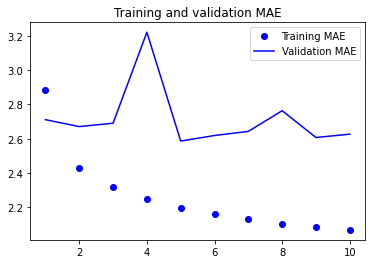

In [21]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Let's try a 1D convolutional model

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 26s 31ms/step - loss: 22.2297 - mae: 3.6879 - val_loss: 18.5067 - val_mae: 3.4575
Epoch 2/10
819/819 [==============================] - 26s 32ms/step - loss: 15.5387 - mae: 3.1292 - val_loss: 15.9798 - val_mae: 3.1802
Epoch 3/10
819/819 [==============================] - 24s 30ms/step - loss: 14.5538 - mae: 3.0169 - val_loss: 14.8220 - val_mae: 3.0354
Epoch 4/10
819/819 [==============================] - 25s 31ms/step - loss: 13.8255 - mae: 2.9324 - val_loss: 15.1413 - val_mae: 3.0631
Epoch 5/10
819/819 [==============================] - 25s 30ms/step - loss: 13.3088 - mae: 2.8745 - val_loss: 15.0597 - val_mae: 3.0559
Epoch 6/10
819/819 [==============================] - 25s 30ms/step - loss: 12.8408 - mae: 2.8238 - val_loss: 16.0358 - val_mae: 3.1556
Epoch 7/10
819/819 [==============================] - 25s 31ms/step - loss: 12.4231 - mae: 2.7772 - val_loss: 16.1009 - val_mae: 3.1414
Epoch 8/10
819/819 [============================

**Plotting results**

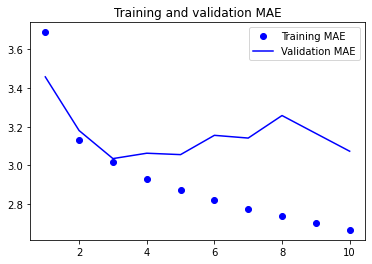

In [23]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### A first recurrent baseline

**A simple LSTM-based model with Dense 16**

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 39s 46ms/step - loss: 38.2989 - mae: 4.4968 - val_loss: 11.7446 - val_mae: 2.6135
Epoch 2/10
819/819 [==============================] - 38s 47ms/step - loss: 10.6044 - mae: 2.5282 - val_loss: 9.7137 - val_mae: 2.4335
Epoch 3/10
819/819 [==============================] - 42s 51ms/step - loss: 9.6890 - mae: 2.4220 - val_loss: 9.6833 - val_mae: 2.4291
Epoch 4/10
819/819 [==============================] - 40s 49ms/step - loss: 9.3044 - mae: 2.3709 - val_loss: 9.4734 - val_mae: 2.3966
Epoch 5/10
819/819 [==============================] - 35s 43ms/step - loss: 8.9471 - mae: 2.3250 - val_loss: 9.7920 - val_mae: 2.4375
Epoch 6/10
819/819 [==============================] - 33s 40ms/step - loss: 8.6403 - mae: 2.2875 - val_loss: 9.9809 - val_mae: 2.4515
Epoch 7/10
819/819 [==============================] - 38s 46ms/step - loss: 8.3882 - mae: 2.2524 - val_loss: 10.1379 - val_mae: 2.4777
Epoch 8/10
819/819 [==============================] - 36s 

**Plotting results**

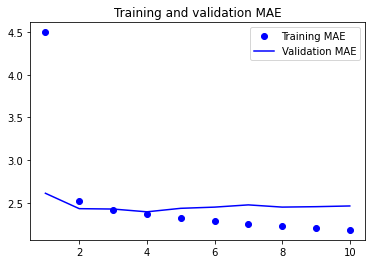

In [25]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**A simple LSTM-based model with Dense 32**

In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 63ms/step - loss: 21.3527 - mae: 3.3218 - val_loss: 9.8108 - val_mae: 2.4120
Epoch 2/10
819/819 [==============================] - 49s 60ms/step - loss: 8.9880 - mae: 2.3441 - val_loss: 9.7837 - val_mae: 2.4170
Epoch 3/10
819/819 [==============================] - 52s 63ms/step - loss: 8.1463 - mae: 2.2268 - val_loss: 10.0707 - val_mae: 2.4476
Epoch 4/10
819/819 [==============================] - 49s 59ms/step - loss: 7.6097 - mae: 2.1503 - val_loss: 10.1339 - val_mae: 2.4689
Epoch 5/10
819/819 [==============================] - 45s 55ms/step - loss: 7.2168 - mae: 2.0931 - val_loss: 10.6482 - val_mae: 2.5399
Epoch 6/10
819/819 [==============================] - 50s 61ms/step - loss: 6.8485 - mae: 2.0384 - val_loss: 10.9769 - val_mae: 2.5736
Epoch 7/10
819/819 [==============================] - 51s 62ms/step - loss: 6.5607 - mae: 1.9946 - val_loss: 10.9052 - val_mae: 2.5698
Epoch 8/10
819/819 [==============================] - 53

**Plotting results**

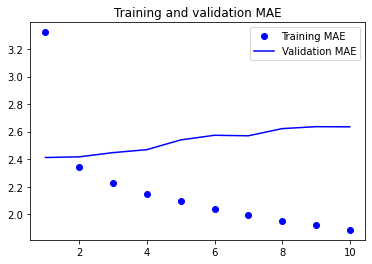

In [27]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**A simple LSTM-based model with Dense 64**

In [36]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 93s 112ms/step - loss: 14.5536 - mae: 2.8049 - val_loss: 9.9137 - val_mae: 2.4759
Epoch 2/10
819/819 [==============================] - 89s 108ms/step - loss: 7.7493 - mae: 2.1727 - val_loss: 10.1414 - val_mae: 2.4989
Epoch 3/10
819/819 [==============================] - 88s 108ms/step - loss: 6.2542 - mae: 1.9440 - val_loss: 10.9031 - val_mae: 2.6124
Epoch 4/10
819/819 [==============================] - 90s 110ms/step - loss: 5.2248 - mae: 1.7715 - val_loss: 11.1763 - val_mae: 2.6323
Epoch 5/10
819/819 [==============================] - 90s 110ms/step - loss: 4.5190 - mae: 1.6425 - val_loss: 11.4128 - val_mae: 2.6603
Epoch 6/10
819/819 [==============================] - 89s 108ms/step - loss: 3.9307 - mae: 1.5256 - val_loss: 12.1055 - val_mae: 2.7367
Epoch 7/10
819/819 [==============================] - 88s 108ms/step - loss: 3.4888 - mae: 1.4369 - val_loss: 12.0399 - val_mae: 2.7393
Epoch 8/10
819/819 [============================

**Plotting results**

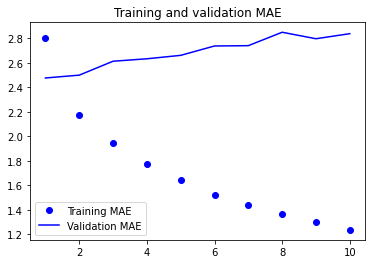

In [37]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**

In [38]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [39]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [40]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [41]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [42]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a combination of 1d_Convnet and dropout-regularized LSTM**

In [43]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(32, 5, activation="relu", padding="same")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.LSTM(64, recurrent_dropout=0.25)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 63s 74ms/step - loss: 16.9194 - mae: 3.1015 - val_loss: 10.3037 - val_mae: 2.5020
Epoch 2/10
819/819 [==============================] - 60s 73ms/step - loss: 11.1376 - mae: 2.5988 - val_loss: 9.8968 - val_mae: 2.4397
Epoch 3/10
819/819 [==============================] - 61s 74ms/step - loss: 9.7803 - mae: 2.4274 - val_loss: 10.2925 - val_mae: 2.5130
Epoch 4/10
819/819 [==============================] - 61s 75ms/step - loss: 8.7840 - mae: 2.2882 - val_loss: 10.6391 - val_mae: 2.5420
Epoch 5/10
819/819 [==============================] - 61s 75ms/step - loss: 8.0154 - mae: 2.1805 - val_loss: 11.1962 - val_mae: 2.6297
Epoch 6/10
819/819 [==============================] - 61s 74ms/step - loss: 7.4194 - mae: 2.0917 - val_loss: 11.8224 - val_mae: 2.7070
Epoch 7/10
819/819 [==============================] - 61s 74ms/step - loss: 6.9193 - mae: 2.0193 - val_loss: 11.8553 - val_mae: 2.6978
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

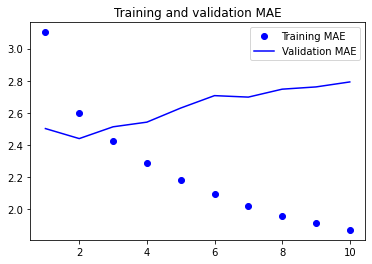

In [44]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [45]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked LSTM model**

In [46]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 149s 178ms/step - loss: 25.7697 - mae: 3.7564 - val_loss: 9.9786 - val_mae: 2.4382
Epoch 2/10
819/819 [==============================] - 146s 178ms/step - loss: 13.6101 - mae: 2.8564 - val_loss: 9.7934 - val_mae: 2.4336
Epoch 3/10
819/819 [==============================] - 148s 180ms/step - loss: 12.3832 - mae: 2.7229 - val_loss: 9.9396 - val_mae: 2.4732
Epoch 4/10
819/819 [==============================] - 147s 180ms/step - loss: 11.4439 - mae: 2.6125 - val_loss: 10.4649 - val_mae: 2.5469
Epoch 5/10
819/819 [==============================] - 148s 181ms/step - loss: 10.7232 - mae: 2.5242 - val_loss: 9.9930 - val_mae: 2.4727
Epoch 6/10
819/819 [==============================] - 145s 178ms/step - loss: 10.1543 - mae: 2.4539 - val_loss: 10.6136 - val_mae: 2.5489
Epoch 7/10
819/819 [==============================] - 147s 179ms/step - loss: 9.7073 - mae: 2.4005 - val_loss: 10.4126 - val_mae: 2.5244
Epoch 8/10
819/819 [===================

**Plotting results**

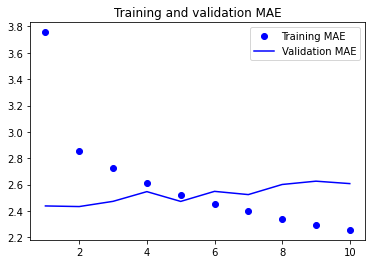

In [47]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [48]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16,recurrent_dropout=0.25))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 90s 105ms/step - loss: 26.5152 - mae: 3.7255 - val_loss: 10.8732 - val_mae: 2.5499
Epoch 2/10
819/819 [==============================] - 85s 104ms/step - loss: 9.8607 - mae: 2.4536 - val_loss: 9.9145 - val_mae: 2.4398
Epoch 3/10
819/819 [==============================] - 85s 104ms/step - loss: 8.9717 - mae: 2.3360 - val_loss: 9.8620 - val_mae: 2.4366
Epoch 4/10
819/819 [==============================] - 86s 105ms/step - loss: 8.4879 - mae: 2.2764 - val_loss: 9.9146 - val_mae: 2.4437
Epoch 5/10
819/819 [==============================] - 86s 105ms/step - loss: 8.1358 - mae: 2.2290 - val_loss: 9.9742 - val_mae: 2.4491
Epoch 6/10
819/819 [==============================] - 86s 104ms/step - loss: 7.8347 - mae: 2.1853 - val_loss: 10.2091 - val_mae: 2.4724
Epoch 7/10
819/819 [==============================] - 85s 103ms/step - loss: 7.5430 - mae: 2.1452 - val_loss: 10.4170 - val_mae: 2.5077
Epoch 8/10
819/819 [==============================]

**Plotting results**

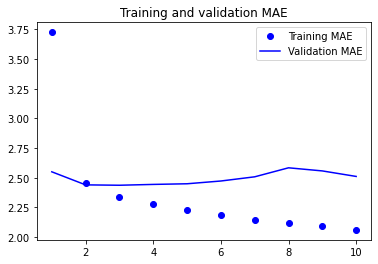

In [49]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()